In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
import os
import rasterio
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
import cartopy

In [4]:
for yl in range(38):
    DIR = f'./prism/data/tmax/{1981+yl}/'
    fna = [name for name in os.listdir(DIR)]
    fna.sort()
    fno = len(fna)
    for i in range(fno):
        z = ZipFile(DIR+fna[i])
        z.extractall(DIR+fna[i][:-4])

In [14]:
for yl in range(1,38):
    tmax = []
    folder = f'./prism/data/tmax/{1981+yl}/'
    subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
    for i in range(len(subfolders)):
        bil = rasterio.open(subfolders[i]+'/'+subfolders[i][23:]+'.bil')
        a = bil.read()[0, :357, 479:1201]
        tmax.append(a)
    tmax = np.array(tmax)
    np.savez_compressed(f'./prism/mw_tmax/{1981+yl}_tmax', tmax=tmax)

In [19]:
for yl in range(18):
    DIR = f'./prism/data/prec/{2001+yl}/'
    fna = [name for name in os.listdir(DIR)]
    fna.sort()
    fno = len(fna)
    for i in range(fno):
        z = ZipFile(DIR+fna[i])
        z.extractall(DIR+fna[i][:-4])

In [ ]:
for yl in range(38):
    prec = []
    folder = f'./prism/data/prec/{1981+yl}/'
    subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
    for i in range(len(subfolders)):
        bil = rasterio.open(subfolders[i]+'/'+subfolders[i][23:]+'.bil')
        a = bil.read()[0, :357, 479:1201]
        prec.append(a)
    prec = np.array(prec)
    np.savez_compressed(f'./prism/mw_prec/{1981+yl}_prec', prec=prec)

In [3]:
lat = np.array([49.9166666666664 - i * 0.0416666666667 for i in range(357)])
lon = np.array([-105.0416666666507 + i * 0.0416666666667 for i in range(722)])
Lon, Lat = np.meshgrid(lon, lat)

In [4]:
am = rasterio.open('PRISM_tmin_stable_4kmD2_19810101_bil.bil')
a = am.read()[0, :357, 479:1201]
mask = np.where(a>-1000, 1, 0)

In [5]:
tmin81 = np.load('./prism/mw_tmin/1981_tmin.npz')['tmin']
t, y, x = tmin81.shape

In [95]:
dff = pd.date_range(start='1/1/1981', end='12/31/2018', freq='D')
year = np.array(dff.strftime('%Y')).astype(int)
year = np.delete(year, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])
mon = np.array(dff.strftime('%-m')).astype(int)
mon = np.delete(mon, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])
day = np.array(dff.strftime('%-d')).astype(int)
day = np.delete(day, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])

In [124]:
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            tminij = []
            tmaxij = []
            precij = []
            for yl in range(38):
                tmin = np.load(f'./prism/mw_tmin/{1981+yl}_tmin.npz')['tmin']
                tminij.extend(tmin[:, i, j])
                tmax = np.load(f'./prism/mw_tmax/{1981+yl}_tmax.npz')['tmax']
                tmaxij.extend(tmax[:, i, j])
                prec = np.load(f'./prism/mw_prec/{1981+yl}_prec.npz')['prec']
                precij.extend(prec[:, i, j])
            tminij = np.array(tminij)
            tminij = np.delete(tminij, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])
            tmaxij = np.array(tmaxij)
            tmaxij = np.delete(tmaxij, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])
            precij = np.array(precij)
            precij = np.delete(precij, [1154, 2615, 4076, 5537, 6998, 8459, 9920, 11381, 12842])


            f = open(f'./prism/GDD_data/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_1981-2018.txt', "a")
            f.write('YEAR,MONTH,DAY,MAX,MIN,PREC\n')
            for k in range(len(year)):
                f.write(f'{year[k]}, {mon[k]}, {day[k]}, {tmaxij[k]:.1f}, {tminij[k]:.1f}, {precij[k]:.2f}\n')
            f.close()

In [24]:
DIR = './prism/GDD_data'
fna = [name for name in os.listdir(DIR)]
fna.sort()
fno = len(fna)
for filename in fna:
    os.rename(os.path.join(DIR, filename), os.path.join(DIR, filename.replace(" ", "")))

In [18]:
flag = []
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            flag.append(f'{Lat[i, j]:5.2f}_{Lon[i, j]:7.2f}_1981-2018.txt')

In [19]:
f = open('./GDD/input_list.txt', 'w')
for ii in range(fno):
    if fna[ii] in flag:
        f.write(f'{fna[ii].replace(" ", "")}\n')
f.close()

In [20]:
f1 = open('./GDD/output_daily_list.txt', 'w')
f2 = open('./GDD/output_yearly_list.txt', 'w')
for ii in range(fno):
    if fna[ii] in flag:
        f1.write(f'{fna[ii].replace(" ", "").replace("1981-2018", "daily")}\n')
        f2.write(f'{fna[ii].replace(" ", "").replace("1981-2018", "yearly")}\n')
f1.close()
f2.close()

In [22]:
gdd = np.zeros((y, x)) * np.nan
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output/daily/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_daily.txt', delim_whitespace=True, 
                                   names=('YR','cd','TMAX','TMIN','gdd','CDHTOT','STAGE','DAM','YLD','INJDAYS'))
            gdd[i,j] = np.array([df.gdd[59+365*i:151+365*i].sum() for i in range(38)]).mean()

In [23]:
np.save('gdd', gdd)

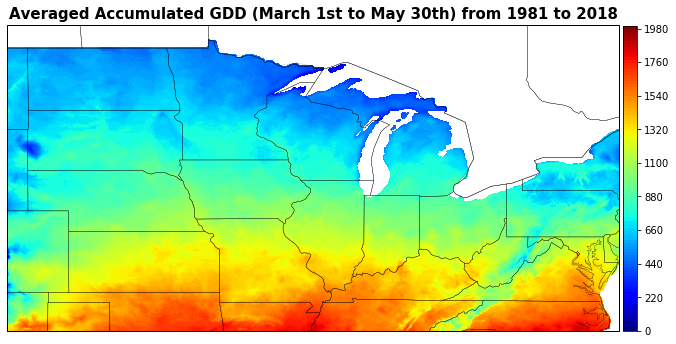

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')

pc = plt.contourf(Lon, Lat, gdd, cmap='jet', levels=np.linspace(0, 2000, 101))
plt.title('Averaged Accumulated GDD (March 1st to May 30th) from 1981 to 2018', fontsize=15, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.21, 0.02, 0.53])
cbar = fig.colorbar(pc, cax=cb_ax)
plt.savefig('./plot/gdd_ave.png')

In [11]:
var = [np.zeros((y, x)) * np.nan for i in range(5)]
name = ['year','fgreen','bloom','yeild','INJDAYS','POORDAYS']

for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
            for ii in range(1,6):
                var[ii-1][i,j] = df[name[ii]].mean()

np.save('./GDD/var_yearly', np.array(var))

In [6]:
var_mean = np.load('./GDD/var_yearly.npy')

var_std = [np.zeros((y, x)) * np.nan for i in range(5)]
name = ['year','fgreen','bloom','yeild','INJDAYS','POORDAYS']

for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
            for ii in range(1,6):
                var_detrend = df[name[ii]] - var_mean[ii-1, i, j]
                var_std[ii-1][i,j] = np.sqrt(((var_detrend - var_detrend.mean())**2).sum() / 38.)

np.save('./GDD/var_std', np.array(var_std))

In [20]:
slope = [np.zeros((y, x)) * np.nan for i in range(5)]
pvalue = [np.zeros((y, x)) * np.nan for i in range(5)]
name = ['year','fgreen','bloom','yeild','INJDAYS','POORDAYS']
X = np.linspace(1, 38, 38)

for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
            for ii in range(1,6):
                r = stats.linregress(X, df[name[ii]])
                slope[ii-1][i, j] = r.slope
                pvalue[ii-1][i, j] = r.pvalue

np.save('./GDD/var_yearly_slope', np.array(slope))
np.save('./GDD/var_yearly_pvalue', np.array(pvalue))

In [1]:
var_mean = np.load('./GDD/var_yearly.npy')
name = ['FGREEN','BLOOM','YIELD','INJDAYS','POORDAYS']
for ii in range(3,4):
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.3, edgecolor="black")
    ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    
    levels = MaxNLocator(nbins=100).tick_values(0, 6)
    cmap = plt.get_cmap('jet')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, var_mean[ii, :, :], cmap=cmap, norm=norm)
    
    plt.title(f'Averaged {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

    fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
    cb_ax = fig.add_axes([0.905, 0.21, 0.02, 0.53])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=[0, 1, 2, 3, 4, 5, 6], extend='max')
    plt.savefig(f'./plot/PRISM/{name[ii]}_mean.png')

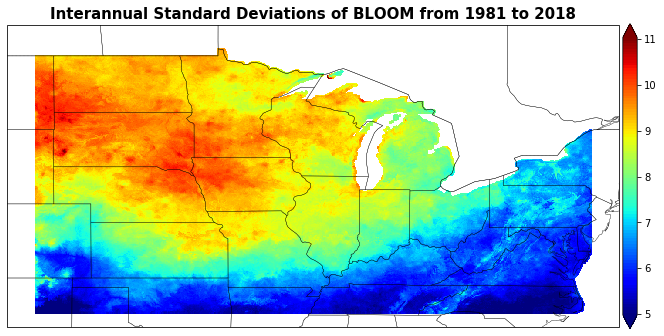

In [7]:
var_std = np.load('./GDD/var_std.npy')
name = ['FGREEN','BLOOM','YIELD','INJDAYS','POORDAYS']
for ii in range(1,2):
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.3, edgecolor="black")
    ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    
    levels = MaxNLocator(nbins=100).tick_values(5, 11)
    cmap = plt.get_cmap('jet')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, var_std[ii, :, :], cmap=cmap, norm=norm)
    
    plt.title(f'Interannual Standard Deviations of {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

    fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
    cb_ax = fig.add_axes([0.905, 0.21, 0.02, 0.53])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=[5, 6, 7, 8, 9, 10, 11], extend='both')
    plt.savefig(f'./plot/PRISM/{name[ii]}_std.png')

/home/mmfire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


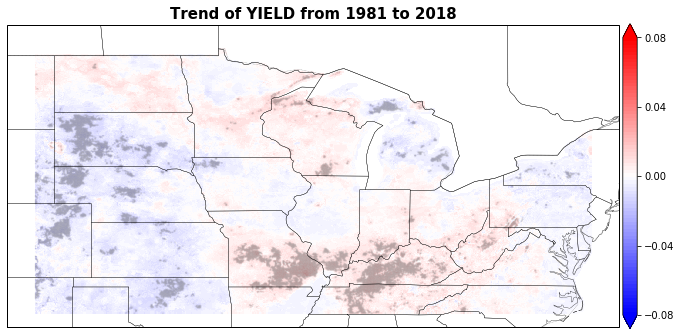

In [36]:
slope = np.load('./GDD/var_yearly_slope.npy')
pvalue = np.load('./GDD/var_yearly_pvalue.npy')
name = ['FGREEN','BLOOM','YIELD','INJDAYS','POORDAYS']
for ii in range(2,3):
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.3, edgecolor="black")
    ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
    
    levels = MaxNLocator(nbins=100).tick_values(-.08, .08)
    cmap = plt.get_cmap('bwr')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, slope[ii, :, :], cmap=cmap, norm=norm)
    
    plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1)
    
    plt.title(f'Trend of {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

    fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
    cb_ax = fig.add_axes([0.905, 0.21, 0.02, 0.53])
    cbar = fig.colorbar(pc, cax=cb_ax, ticks=[-.08, -.04, 0, .04, .08], extend='both')
    plt.savefig(f'./plot/PRISM/{name[ii]}_trend.png')
#     plt.close()

<ipython-input-42-9df0154efbe2>:26: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


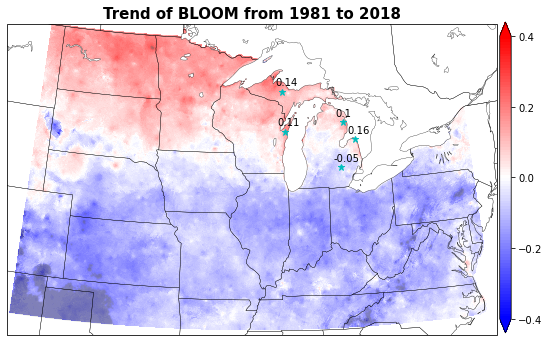

In [42]:
slope = np.load('./GDD/var_yearly_slope.npy')
pvalue = np.load('./GDD/var_yearly_pvalue.npy')
name = ['FGREEN','BLOOM','YIELD','INJDAYS','POORDAYS']
ii = 1
extent = [-105, -75, 34, 49]
loclat = [44.83, 44.50, 44.00, 46.42, 42.71]
loclon = [-83.58, -87.71, -82.83, -87.83, -83.92]
r = [0.10, 0.11, 0.16, 0.14, -0.05]
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-.4, .4)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, slope[ii, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
for k in range(5):
    ax.plot(loclon[k], loclat[k], 'c*', markersize=7, transform=ccrs.PlateCarree())
#     ax.text(loclon[k]-1, loclat[k]+1, f'({loclon[k]}, {loclat[k]})', transform=ccrs.PlateCarree())
    ax.text(loclon[k]-.5, loclat[k]+.3, f'{r[k]}', transform=ccrs.PlateCarree())

plt.title(f'Trend of {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=[-.4, -.2, 0, .2, .4], extend='both')
plt.savefig(f'./plot/PRISM/{name[ii]}_trend_star.png')

0.10471605208447313

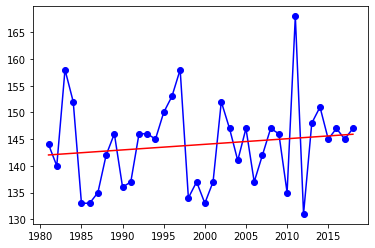

In [7]:
df = pd.read_table(f'./GDD/output/yearly/44.83_-83.58_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
r = stats.linregress(X, df.bloom)
plt.plot(X, df.bloom, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
r.slope

0.1129226392384287

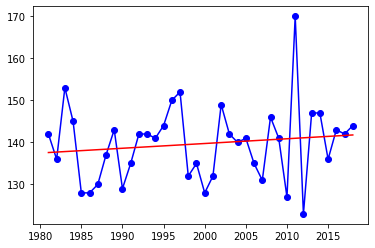

In [8]:
df = pd.read_table(f'./GDD/output/yearly/44.50_-87.71_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
r = stats.linregress(X, df.bloom)
plt.plot(X, df.bloom, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
r.slope

0.16270926797242585

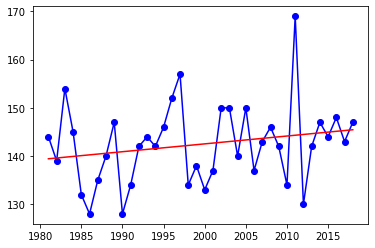

In [9]:
df = pd.read_table(f'./GDD/output/yearly/44.00_-82.83_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
r = stats.linregress(X, df.bloom)
plt.plot(X, df.bloom, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
r.slope

0.13863661232082283

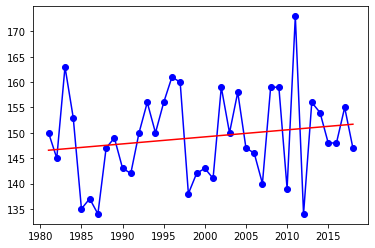

In [40]:
df = pd.read_table(f'./GDD/output/yearly/46.42_-87.83_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
r = stats.linregress(X, df.bloom)
plt.plot(X, df.bloom, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
r.slope

-0.05295984243352664

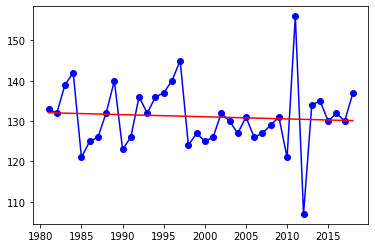

In [38]:
df = pd.read_table(f'./GDD/output/yearly/42.71_-83.92_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
r = stats.linregress(X, df.bloom)
plt.plot(X, df.bloom, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
r.slope

<ipython-input-50-f9caf1d5c405>:27: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


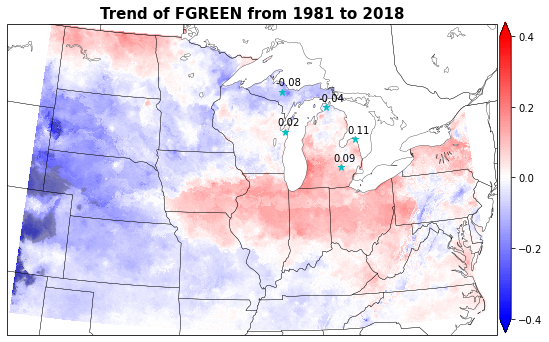

In [50]:
slope = np.load('./GDD/var_yearly_slope.npy')
pvalue = np.load('./GDD/var_yearly_pvalue.npy')
name = ['FGREEN','BLOOM','YIELD','INJDAYS','POORDAYS']
ii = 0
extent = [-105, -75, 34, 49]
loclat = [45.62, 44.50, 44.00, 46.42, 42.71]
loclon = [-84.71, -87.71, -82.83, -87.83, -83.92]
r = [-0.04, 0.02, 0.11, -0.08, 0.09]

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-.4, .4)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, slope[ii, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.scatter(Lon, Lat, np.where(pvalue[ii, :, :]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
for k in range(5):
    ax.plot(loclon[k], loclat[k], 'c*', markersize=7, transform=ccrs.PlateCarree())
#     ax.text(loclon[k]-1, loclat[k]+1, f'({loclon[k]}, {loclat[k]})', transform=ccrs.PlateCarree())
    ax.text(loclon[k]-.5, loclat[k]+.3, f'{r[k]}', transform=ccrs.PlateCarree())

plt.title(f'Trend of {name[ii]} from 1981 to 2018', fontsize=15, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=[-.4, -.2, 0, .2, .4], extend='both')
plt.savefig(f'./plot/PRISM/{name[ii]}_trend_star.png')

-0.04004814531130321

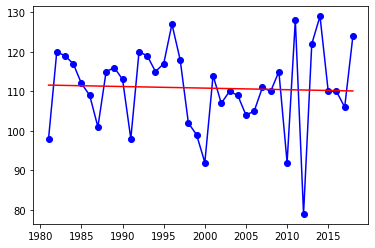

In [49]:
df = pd.read_table(f'./GDD/output/yearly/45.62_-84.71_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
r = stats.linregress(X, df.fgreen)
plt.plot(X, df.fgreen, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
r.slope

0.019805230331546124

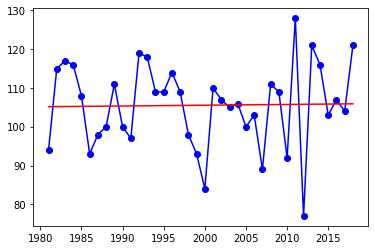

In [44]:
df = pd.read_table(f'./GDD/output/yearly/44.50_-87.71_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
r = stats.linregress(X, df.fgreen)
plt.plot(X, df.fgreen, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
r.slope

0.11456395666921981

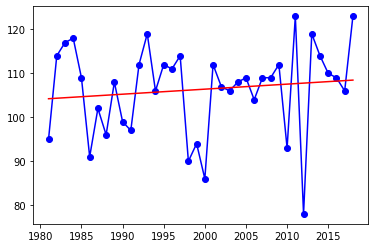

In [45]:
df = pd.read_table(f'./GDD/output/yearly/44.00_-82.83_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
r = stats.linregress(X, df.fgreen)
plt.plot(X, df.fgreen, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
r.slope

-0.08097165991902834

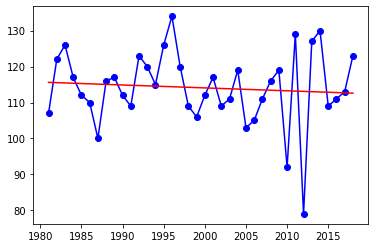

In [46]:
df = pd.read_table(f'./GDD/output/yearly/46.42_-87.83_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
r = stats.linregress(X, df.fgreen)
plt.plot(X, df.fgreen, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
r.slope

0.08666156034577087

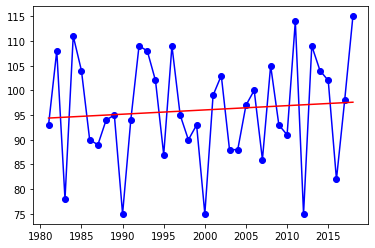

In [47]:
df = pd.read_table(f'./GDD/output/yearly/42.71_-83.92_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
X = np.linspace(1981, 2018, 38)
r = stats.linregress(X, df.fgreen)
plt.plot(X, df.fgreen, 'bo-')
plt.plot(X, r.slope*X+r.intercept, 'r')
r.slope